<a href="https://colab.research.google.com/github/JoMihye/Project/blob/master/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (1) Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sklearn

# (2) Image 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/MyDrive/ColabNotebooks/darknet/apple'
path = './'
os.chdir(file_path)  # Apple Image가 있는 폴더로 경로 변경
file_lst = os.listdir(path)  # 지정한 폴더 내의 모든 파일 리스트를 저장

In [ ]:
apple_lst = []
for file in file_lst:
    apple_lst.append(plt.imread(file))

In [ ]:
os.chdir('/content/gdrive/MyDrive/ColabNotebooks/darknet/custom/')

# (3) X, y

* 정상 사과(0)와 병든 사과(1) 각각 500개 중 80%를 train set, 20%를 test set으로 설정
* txt 파일로 저장

In [ ]:
# # train, test txt file
# import random as rd

# all_num = list(np.arange(1, 501))
# train_num = rd.sample(all_num, int(len(all_num) * 0.8))
# test_num = list(set(all_num).difference(train_num))
# f = open('train.txt', 'w') # train.txt 생성
# for i in range(0,2):
#     for n in train_num:
#         data = path + 'apple_' + str(i) +'_' + format(n, '03') + '.jpg\n'
#         f.write(data)
# f.close()

# f = open('test.txt', 'w') # test.txt 생성
# for i in range(0,2):
#     for n in test_num:
#         data = path + 'apple_' + str(i) +'_' + format(n, '03') + '.jpg\n'
#         f.write(data)
# f.close()

In [ ]:
X_tr = []
with open('train.txt', mode='rt') as f:
    for line in f:
        l = line.strip()
        train_num = file_path + '/' + l[-15:]
        X_tr.append(cv2.imread(train_num))
X_tr = np.asarray(X_tr)

In [ ]:
X_te = []
with open('test.txt', mode='rt') as f:
    for line in f:
        l = line.strip()
        test_num = file_path + '/' + l[-15:]
        X_te.append(cv2.imread(test_num))
X_te = np.asarray(X_te)

In [ ]:
y_tr = []
with open('train.txt', mode='rt') as f:
    for line in f:
        a = line.strip()
        y_tr.append(int(a[-9:-8]))
y_tr = np.asarray(y_tr)

In [ ]:
y_te = []
with open('test.txt', mode='rt') as f:
    for line in f:
        a = line.strip()
        y_te.append(int(a[-9:-8]))
y_te = np.asarray(y_te)

In [ ]:
print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(800, 256, 256, 3) (200, 256, 256, 3) (800,) (200,)


In [ ]:
# Scaling (0 ~ 255 -> [0, 1) int)
X_tr = X_tr / 255
X_te = X_te / 255

In [ ]:
# 분석을 위해 배열의 차원을 4차원에서 2차원으로 축소
X_tr_rs = X_tr.reshape(800, -1)
X_te_rs = X_te.reshape(200, -1)
print(X_tr_rs.shape, X_te_rs.shape)

(800, 196608) (200, 196608)


# (4) Classification model

## 1. K-Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_tr_rs, y_tr)
print('=== KNeighborsClassifier n_neighbors = 5 (default) ===')
print('KNN Score (Train) :', knn.score(X_tr_rs, y_tr))  # train score: 0.70125
print('KNN Score (Test) :', knn.score(X_te_rs, y_te))  # test score: 0.635

=== KNeighborsClassifier n_neighbors = 5 (default) ===
KNN Score (Train) : 0.70125
KNN Score (Test) : 0.635


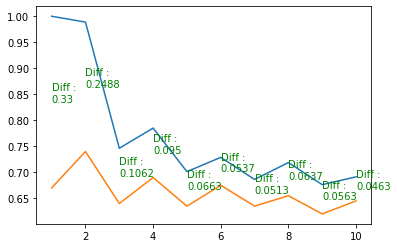

In [ ]:
# KNN plot - neighbors 개수에 따른 score 시각화
tr_score = []
te_score = []
neighbors = range(1, 11)
for x in neighbors:
    knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=x)
    knn.fit(X_tr_rs, y_tr)
    tr_score.append(knn.score(X_tr_rs, y_tr))
    te_score.append(knn.score(X_te_rs, y_te))

plt.plot(neighbors, tr_score, label='Train Score')
plt.plot(neighbors, te_score, label='Test Score')
for i in range(len(tr_score)):
    plt.text(neighbors[i], ( tr_score[i] + te_score[i] )/ 2 , f'Diff : \n{round((tr_score[i] - te_score[i]), 4)}', color='green')
plt.show()
# n=4 ⇒ low diff & high accuracy (과대적합이 적고, 정확도가 높음) ∴ best

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn.fit(X_tr_rs, y_tr)
print('=== KNeighbors Classifier n_neighbors = 4 (best) ===')
print('KNN Score (Train) :', knn.score(X_tr_rs, y_tr)) # train score : 0.785
print('KNN Score (Test) :', knn.score(X_te_rs, y_te)) # test score : 0.69

=== KNeighbors Classifier n_neighbors = 4 (best) ===
KNN Score (Train) : 0.785
KNN Score (Test) : 0.69


In [ ]:
# confusion matrix (train, knn)
from sklearn.metrics import confusion_matrix, classification_report

tr_pred_knn = knn.predict(X_tr_rs)
print(confusion_matrix(y_tr, tr_pred_knn))

[[233 167]
 [  5 395]]


In [ ]:
# classification report (train, knn)
print(classification_report(y_tr, tr_pred_knn, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       0.98      0.58      0.73       400
    DmgApple       0.70      0.99      0.82       400

    accuracy                           0.79       800
   macro avg       0.84      0.79      0.78       800
weighted avg       0.84      0.79      0.78       800



In [ ]:
# confusion matrix (test, knn)
te_pred_knn = knn.predict(X_te_rs)
print(confusion_matrix(y_te, te_pred_knn))

[[42 58]
 [ 4 96]]


In [ ]:
# classification report (test, knn)
print(classification_report(y_te, te_pred_knn, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       0.91      0.42      0.58       100
    DmgApple       0.62      0.96      0.76       100

    accuracy                           0.69       200
   macro avg       0.77      0.69      0.67       200
weighted avg       0.77      0.69      0.67       200



## 2. SGD

In [ ]:
# SGD Classifier (hinge)
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', max_iter=30)
sgd.fit(X_tr_rs, y_tr)
print('=== SGD Classifier (hinge) ===')
print('SGD Score (Train) :', sgd.score(X_tr_rs, y_tr)) # train score : 1.0
print('SGD Score (Test) :', sgd.score(X_te_rs, y_te)) # test score : 0.915

=== SGD Classifier (hinge) ===
SGD Score (Train) : 1.0
SGD Score (Test) : 0.915


In [ ]:
# confusion matrix (train, sgd, 'hinge')
tr_pred_sgd = sgd.predict(X_tr_rs) 
print(confusion_matrix(y_tr, tr_pred_sgd))

[[400   0]
 [  0 400]]


In [ ]:
# classification report (train, sgd, 'hinge')
print(classification_report(y_tr, tr_pred_sgd, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       400
    DmgApple       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [ ]:
# confusion matrix (test, sgd, 'hinge')
te_pred_sgd = sgd.predict(X_te_rs)
print(confusion_matrix(y_te, te_pred_sgd))

[[93  7]
 [10 90]]


In [ ]:
# classification report (test, sgd, 'hinge')
print(classification_report(y_te, te_pred_sgd, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       0.90      0.93      0.92       100
    DmgApple       0.93      0.90      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



In [ ]:
# SGD Classifier (log)
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', max_iter=30)
sgd.fit(X_tr_rs, y_tr)
print('=== SGD Classifier (log_loss) ===')
print('SGD Score (Train) :', sgd.score(X_tr_rs, y_tr)) # train score : 1.0
print('SGD Score (Test) :', sgd.score(X_te_rs, y_te)) # test score : 0.89

=== SGD Classifier (log_loss) ===
SGD Score (Train) : 1.0
SGD Score (Test) : 0.89


In [ ]:
# confusion matrix (train, sgd, 'log')
tr_pred_sgd = sgd.predict(X_tr_rs)
print(confusion_matrix(y_tr, tr_pred_sgd))

[[400   0]
 [  0 400]]


In [ ]:
# classification report (train, sgd, 'log')
print(classification_report(y_tr, tr_pred_sgd, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       400
    DmgApple       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [ ]:
# confusion matrix (test, sgd, 'log')
te_pred_sgd = sgd.predict(X_te_rs)
print(confusion_matrix(y_te, te_pred_sgd))

[[88 12]
 [10 90]]


In [ ]:
# classification report (test, sgd, 'log')
print(classification_report(y_te, te_pred_sgd, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       0.90      0.88      0.89       100
    DmgApple       0.88      0.90      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



## 3. Logistic Regression

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1, max_iter=30)
lr.fit(X_tr_rs, y_tr)
print('=== Logistic Regression ===')
print('Logistic Regression Score (Train) :', lr.score(X_tr_rs, y_tr)) # train score : 1.0
print('Logistic Regression Score (Test) :', lr.score(X_te_rs, y_te)) # test score : 0.905

=== Logistic Regression ===
Logistic Regression Score (Train) : 1.0
Logistic Regression Score (Test) : 0.905


In [ ]:
# confusion matrix (train, logistic)
tr_pred_lr = lr.predict(X_tr_rs)
print(confusion_matrix(y_tr, tr_pred_lr))

[[400   0]
 [  0 400]]


In [ ]:
# classification report (train, logistic)
print(classification_report(y_tr, tr_pred_lr, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       400
    DmgApple       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [ ]:
# confusion matrix (test, logistic)
te_pred_lr = lr.predict(X_te_rs)
print(confusion_matrix(y_te, te_pred_lr))

[[91  9]
 [10 90]]


In [ ]:
# classification report (test, logistic)
print(classification_report(y_te, te_pred_lr, target_names=['Apple','DmgApple']))

              precision    recall  f1-score   support

       Apple       0.90      0.91      0.91       100
    DmgApple       0.91      0.90      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



# (5) PCA

In [ ]:
from sklearn.decomposition import PCA
pca_rgb = []
for i in X_tr:
    b, g, r = cv2.split(i)
    r = r / 255
    g = g / 255
    b = b / 255
    pca_r = PCA(n_components=32)
    pca_r_tran = pca_r.fit_transform(r)
    pca_g = PCA(n_components=32)
    pca_g_tran = pca_g.fit_transform(g)
    pca_b = PCA(n_components=32)
    pca_b_tran = pca_b.fit_transform(b)

    pca_r_org = pca_r.inverse_transform(pca_r_tran)
    pca_g_org = pca_g.inverse_transform(pca_g_tran)
    pca_b_org = pca_b.inverse_transform(pca_b_tran)

    pca_img = cv2.merge((pca_r_org, pca_g_org, pca_b_org))
    pca_rgb.append(pca_img)

In [ ]:
from sklearn.decomposition import PCA
pca_rgb_te = []
for i in X_te:
    b, g, r = cv2.split(i)
    r = r / 255
    g = g / 255
    b = b / 255
    pca_r = PCA(n_components=32)
    pca_r_tran = pca_r.fit_transform(r)
    pca_g = PCA(n_components=32)
    pca_g_tran = pca_g.fit_transform(g)
    pca_b = PCA(n_components=32)
    pca_b_tran = pca_b.fit_transform(b)

    pca_r_org = pca_r.inverse_transform(pca_r_tran)
    pca_g_org = pca_g.inverse_transform(pca_g_tran)
    pca_b_org = pca_b.inverse_transform(pca_b_tran)

    pca_img = cv2.merge((pca_r_org, pca_g_org, pca_b_org))
    pca_rgb_te.append(pca_img)

In [ ]:
pca_rgb_tr = np.asarray(pca_rgb)
pca_rgb_tr = pca_rgb_tr.reshape((800, -1))
pca_rgb_te = np.asarray(pca_rgb_te)
pca_rgb_te = pca_rgb_te.reshape((200, -1))
print(pca_rgb_tr.shape, pca_rgb_te.shape)

(800, 196608) (200, 196608)


## 1. K-Neighbors Classifier After PCA process

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn.fit(pca_rgb_tr, y_tr)
print('=== KNeighbors Classifier, n_neighbors = 4, PCA O ===')
print('KNN Score (Train) :', knn.score(pca_rgb_tr, y_tr)) # train score : 0.795
print('KNN Score (Test) :', knn.score(pca_rgb_te, y_te)) # test score : 0.69

=== KNeighbors Classifier, n_neighbors = 4, PCA O ===
KNN Score (Train) : 0.795
KNN Score (Test) : 0.69


In [ ]:
# confusion matrix, classification report (train, knn, PCA)
tr_pred_knn_pca = knn.predict(pca_rgb_tr)
print(confusion_matrix(y_tr, tr_pred_knn_pca))
print(classification_report(y_tr, tr_pred_knn_pca, target_names=['Apple','DmgApple']))

[[242 158]
 [  6 394]]
              precision    recall  f1-score   support

       Apple       0.98      0.60      0.75       400
    DmgApple       0.71      0.98      0.83       400

    accuracy                           0.80       800
   macro avg       0.84      0.79      0.79       800
weighted avg       0.84      0.80      0.79       800



In [ ]:
# confusion matrix, classification report (test, knn, PCA)
te_pred_knn_pca = knn.predict(pca_rgb_te)
print(confusion_matrix(y_te, te_pred_knn_pca))
print(classification_report(y_te, te_pred_knn_pca, target_names=['Apple','DmgApple']))

[[42 58]
 [ 4 96]]
              precision    recall  f1-score   support

       Apple       0.91      0.42      0.58       100
    DmgApple       0.62      0.96      0.76       100

    accuracy                           0.69       200
   macro avg       0.77      0.69      0.67       200
weighted avg       0.77      0.69      0.67       200



##2. SGD Classifier After PCA process

In [ ]:
sgd = SGDClassifier(loss='hinge', max_iter=30)
sgd.fit(pca_rgb_tr, y_tr)
print('=== SGD Classifier, PCA O (hinge) ===')
print('SGD Score (Train) :', sgd.score(pca_rgb_tr, y_tr)) # train score : 0.97125
print('SGD Score (Test) :', sgd.score(pca_rgb_te, y_te)) # test score : 0.92

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


=== SGD Classifier, PCA O (hinge) ===
SGD Score (Train) : 0.97125
SGD Score (Test) : 0.92


In [ ]:
# confusion matrix, classification report (train, sgd, 'hinge', PCA)
tr_pred_sgd_pca = sgd.predict(pca_rgb_tr)
print(confusion_matrix(y_tr, tr_pred_sgd_pca))
print(classification_report(y_tr, tr_pred_sgd_pca, target_names=['Apple','DmgApple']))

[[399   1]
 [ 22 378]]
              precision    recall  f1-score   support

       Apple       0.95      1.00      0.97       400
    DmgApple       1.00      0.94      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [ ]:
# confusion matrix, classification report (test, sgd, 'hinge', PCA)
te_pred_sgd_pca = sgd.predict(pca_rgb_te)
print(confusion_matrix(y_te, te_pred_sgd_pca))
print(classification_report(y_tr, tr_pred_sgd_pca, target_names=['Apple','DmgApple']))

[[98  2]
 [14 86]]
              precision    recall  f1-score   support

       Apple       0.95      1.00      0.97       400
    DmgApple       1.00      0.94      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [ ]:
sgd = SGDClassifier(loss='log', max_iter=30)
sgd.fit(pca_rgb_tr, y_tr)
print('=== SGD Classifier, PCA O (log) ===')
print('SGD Score (Train) :', sgd.score(pca_rgb_tr, y_tr)) # train score : 0.94625
print('SGD Score (Test) :', sgd.score(pca_rgb_te, y_te)) # test score : 0.915

=== SGD Classifier, PCA O (log) ===
SGD Score (Train) : 0.94625
SGD Score (Test) : 0.915


In [ ]:
# confusion matrix, classification report (train, sgd, 'log', PCA)
tr_pred_sgd_pca = sgd.predict(pca_rgb_tr)
print(confusion_matrix(y_tr, tr_pred_sgd_pca))
print(classification_report(y_tr, tr_pred_sgd_pca, target_names=['Apple','DmgApple']))

[[399   1]
 [ 42 358]]
              precision    recall  f1-score   support

       Apple       0.90      1.00      0.95       400
    DmgApple       1.00      0.90      0.94       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



In [ ]:
# confusion matrix, classification report (test, sgd, 'log', PCA)
te_pred_sgd_pca = sgd.predict(pca_rgb_te)
print(confusion_matrix(y_te, te_pred_sgd_pca))
print(classification_report(y_tr, tr_pred_sgd_pca, target_names=['Apple','DmgApple']))

[[99  1]
 [16 84]]
              precision    recall  f1-score   support

       Apple       0.90      1.00      0.95       400
    DmgApple       1.00      0.90      0.94       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



##3. Logistic Regression After PCA process

In [ ]:
lr = LogisticRegression(max_iter=30, n_jobs=-1)
lr.fit(pca_rgb_tr, y_tr)
print('=== Logistic Regression, PCA O ===')
print('Logistic Regression Score (Train) :', lr.score(pca_rgb_tr, y_tr)) # train score : 0.90375
print('Logistic Regression Score (Test) :', lr.score(pca_rgb_te, y_te)) # test score : 0.895

=== Logistic Regression, PCA O ===
Logistic Regression Score (Train) : 0.90375
Logistic Regression Score (Test) : 0.895


In [ ]:
# confusion matrix, classification report (train, logistic, PCA)
tr_pred_lr_pca = lr.predict(pca_rgb_tr)
print(confusion_matrix(y_tr, tr_pred_lr_pca))
print(classification_report(y_tr, tr_pred_lr_pca, target_names=['Apple','DmgApple']))

[[365  35]
 [ 42 358]]
              precision    recall  f1-score   support

       Apple       0.90      0.91      0.90       400
    DmgApple       0.91      0.90      0.90       400

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



In [ ]:
# confusion matrix, classification report (test, logistic, PCA)
te_pred_lr_pca = lr.predict(pca_rgb_te)
print(confusion_matrix(y_te, te_pred_lr_pca))
print(classification_report(y_te, te_pred_lr_pca, target_names=['Apple','DmgApple']))

[[93  7]
 [14 86]]
              precision    recall  f1-score   support

       Apple       0.87      0.93      0.90       100
    DmgApple       0.92      0.86      0.89       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200

